In [ ]:
gifrom google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.0 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np

import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text")

print("Path to dataset files:", path)

100%|██████████| 814k/814k [00:00<00:00, 33.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text/versions/1


In [ ]:
# Melihat daftar file dan folder dalam path
files = os.listdir(path)

print("Daftar file dalam path:")
for file in files:
    print(file)

Daftar file dalam path:
data.csv
citation.bib
abusive.csv
README.md
new_kamusalay.csv


#EDA

In [ ]:
data = pd.read_csv(os.path.join(path, "data.csv"), encoding="latin-1")

In [ ]:
data = data.drop(columns=["HS_Weak", "HS_Moderate", "HS_Strong"])

In [ ]:
print(data.shape)

(13169, 10)


In [ ]:
data.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0


In [ ]:
duplicate_tweet_only = data[data.duplicated(subset=['Tweet'])]
print(f"Jumlah tweet yang terduplikat (teks sama, label bisa beda): {len(duplicate_tweet_only)}")

Jumlah tweet yang terduplikat (teks sama, label bisa beda): 146


In [ ]:
# Tampilkan semua tweet yang terduplikasi beserta jumlah kemunculannya
pd.set_option('display.max_rows', None)
print("Contoh semua tweet yang terduplikasi:")
print(duplicate_tweet_only['Tweet'].value_counts())

Contoh semua tweet yang terduplikasi:
Tweet
USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER                                                                                                                                                                     8
USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER                                                                                                                                                                7
USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER                                                                                                                                                           7
USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER                                            

In [ ]:
# Menghapus baris yang merupakan duplikat (berdasarkan kolom 'Tweet')
data = data[~data.duplicated(subset=['Tweet'])]

In [ ]:
print(data.shape)

(13023, 10)


In [ ]:
print(data['HS'].value_counts())
print(data['Abusive'].value_counts())
data[['HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other']].sum()

HS
0    7522
1    5501
Name: count, dtype: int64
Abusive
0    8031
1    4992
Name: count, dtype: int64


,0
HS_Individual,3528
HS_Group,1973
HS_Religion,785
HS_Race,562
HS_Physical,319
HS_Gender,303
HS_Other,3696


#Preprocessing


In [ ]:
# Load Stopword_remover
factory = StopWordRemoverFactory()
stopword_remover = factory.create_stop_word_remover()

In [ ]:
path_kamusalay = "/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/new_kamusalay.csv"

kamus_df = pd.read_csv(path_kamusalay, encoding='latin1', header=None, names=['slang', 'formal'])
kamus_dict = dict(zip(kamus_df['slang'], kamus_df['formal']))

In [ ]:
# Fungsi Standarisasi Teks menggunakan new_kamusalay.csv
def standarize_text(text):
    words = text.split()
    new_words = [kamus_dict.get(word, word) for word in words]
    return ' '.join(new_words)

In [ ]:
# Fungsi preprocessing
def preprocess_text(text):
    if pd.isnull(text):
        return ''

    # Remove Retweet (RT)
    text = re.sub(r'^RT\s+', '', text)

    # Remove Username (USER)
    text = re.sub(r'\bUSER\b', '', text)

    # Case folding
    text = text.lower()

    # Emoji Encodings Removal
    text = re.sub(r'(\\x[0-9a-fA-F]{2})+', '', text)

    # HTML Entites Encodings Removal
    text = re.sub(r'&[a-zA-Z]+;', '', text)

    # Whitespace Encodings Removal
    text = re.sub(r'\\n', ' ', text)

    # Punctuation Removal
    text = re.sub(r'[!"$%&\'()*+,\-./:;<=>?@\[\\\]^{|}~_#]', ' ', text)

    # Standarization
    text = standarize_text(text)

    # Stopword Removal
    text = stopword_remover.remove(text)

    # Number Removal
    text = re.sub(r'\b\d+\b', '', text)

    # One Word Removal
    text = re.sub(r'\b[a-zA-Z]\b', '', text)

    # Multiple Space Removal
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
data['clean_tweet'] = data['Tweet'].apply(preprocess_text)

#Mengeksplorasi Hasil Preprocessing Data

In [ ]:
pd.set_option('display.max_colwidth', None)
data[['Tweet', 'clean_tweet']].head(24)

,Tweet,clean_tweet
0,- disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !',saat semua cowok berusaha melacak perhatian gue kamu lantas remehkan perhatian gue kasih khusus kamu basic kamu cowok bego
1,RT USER: USER siapa yang telat ngasih tau elu?edan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga',siapa telat memberi tau kamu edan sarap gue bergaul cigax jifla calis sama siapa licew
2,"41. Kadang aku berfikir, kenapa aku tetap percaya pada Tuhan padahal aku selalu jatuh berkali-kali. Kadang aku merasa Tuhan itu ninggalkan aku sendirian. Ketika orangtuaku berencana berpisah, ketika kakakku lebih memilih jadi Kristen. Ketika aku anak ter",kadang aku berpikir aku tetap percaya tuhan padahal aku selalu jatuh berkali kali kadang aku merasa tuhan meninggalkan aku sendirian orang tuaku berencana berpisah kakakku lebih memilih jadi kristen aku anak ter
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT TAPI DILIAT DARI MANA ITU AKU',aku aku ku tau matamu sipit dilihat mana aku
4,USER USER Kaum cebong kapir udah keliatan dongoknya dari awal tambah dongok lagi hahahah',kaum cebong kafir kelihatan dongoknya awal tambah dungu haha
5,USER Ya bani taplak dkk \xf0\x9f\x98\x84\xf0\x9f\x98\x84\xf0\x9f\x98\x84',bani taplak kawan kawan
6,deklarasi pilkada 2018 aman dan anti hoax warga dukuh sari jabon,deklarasi pilihan kepala daerah aman anti hoaks warga dukuh sari jabon
7,Gue baru aja kelar re-watch Aldnoah Zero!!! paling kampret emang endingnya! 2 karakter utama cowonya kena friendzone bray! XD URL,gue baru selesai re watch aldnoah zero paling kampret memang akhirnya karakter utama cowoknya kena friendzone bro xd uniform resource locator
8,"Nah admin belanja satu lagi port terbaik nak makan Ais Kepal Milo, Ais Kepal Horlicks atau Cendol Toping kaw kaw. ð??­; ; Doket mano tu ? Gerai Rojak Mertuaku - Taipan 2 (depan TWINS BABY &amp; ROMANTIKA / Bank Islam Senawang) ð???",nah admin belanja satu port terbaik nak makan ais kepal milo ais kepal horlicks cendol toping kau kau ð ­ doket mana gerai rozak mertuaku taipan depan kembar baby romantika bank islam senawang ð
9,USER Enak lg klo smbil ngewe',enak kalau ngewe


In [ ]:
data.loc[543, ['Tweet', 'clean_tweet']]

,543
Tweet,Perbanyaklah membaca CERDAS biar gak dicap goblok :v\n\n#just_kidding\nNB : hanya orang dengan IQ diatas rata-rata yang mengerti tulisan di atas :v'
clean_tweet,perbanyaklah membaca cerdas biar dicap goblok just kidding nb orang intelligence quotient atas rata rata mengerti tulisan atas


In [ ]:
data.loc[271, ['Tweet', 'clean_tweet']]

,271
Tweet,RT USER: Provider brengsek'
clean_tweet,penyedia berengsek


In [ ]:
data.loc[423, ['Tweet', 'clean_tweet']]

,423
Tweet,"BOT mau nanya. 'ich liebe dich' artinya apa? Yg jawab ntar BOT kasih aipet yg barusan nyemplung di jamban kuda (\xe2\x80\xa2\xcc\xaf\xcd\xa1_\xe2\x80\xa2\xcc\xaf\xcd\xa1 )"""
clean_tweet,bot mau bertanya ih liebe ih artinya apa jawab bot kasih ipad barusan mencemplung jamban kuda


In [ ]:
data.loc[166, ['Tweet', 'clean_tweet']]

,166
Tweet,Syg bgt ya ngeliat perempuan kyk gini... Gak ada status apa2 tp udah nemplok sm laki-laki sana sini. Haduh....\nNagita Slavina Blak-blakan Sebut Ayu Ting Ting Kampungan \xe2\x80\x93 VIVA URL
clean_tweet,sayang banget melihat perempuan kayak begini ada status apa apa sudah menempel sama laki laki sana sini aduh nagita slavina blak blak sebut ayu ting ting kampungan viva uniform resource locator


In [ ]:
# contoh yang mengandung encoding whitespace /r
data.loc[9509, ['Tweet', 'clean_tweet']]

,9509
Tweet,"Penggunaan make up/skincare yang mengandung merkuri walau dipake sedikit seperti lipstik di bibir, tapi ternyata dapat meresap melalui pori-pori \xf0\x9f\x98\xb1\r Pada wanita hamil, merkuri yang terserap bisa mengakibatkan pertumbuhan janin terhambat, c"
clean_tweet,penggunaan make up skincare mengandung merkuri dipakai sedikit lipstik bibir ternyata meresap melalui pori pori wanita hamil merkuri terserap mengakibatkan pertumbuhan janin terhambat


In [ ]:
preprocessed_data = data.copy()
preprocessed_data.drop(columns=['Tweet'], inplace=True)
preprocessed_data.rename(columns={'clean_tweet': 'Tweet'}, inplace=True)

cols = ['Tweet'] + [col for col in preprocessed_data.columns if col != 'Tweet']
preprocessed_data = preprocessed_data[cols]

In [ ]:
preprocessed_data.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other
0,saat semua cowok berusaha melacak perhatian gue kamu lantas remehkan perhatian gue kasih khusus kamu basic kamu cowok bego,1,1,1,0,0,0,0,0,1
1,siapa telat memberi tau kamu edan sarap gue bergaul cigax jifla calis sama siapa licew,0,1,0,0,0,0,0,0,0
2,kadang aku berpikir aku tetap percaya tuhan padahal aku selalu jatuh berkali kali kadang aku merasa tuhan meninggalkan aku sendirian orang tuaku berencana berpisah kakakku lebih memilih jadi kristen aku anak ter,0,0,0,0,0,0,0,0,0
3,aku aku ku tau matamu sipit dilihat mana aku,0,0,0,0,0,0,0,0,0
4,kaum cebong kafir kelihatan dongoknya awal tambah dungu haha,1,1,0,1,1,0,0,0,0


Statistik jumlah kata per tweet:
count    13023.000000
mean        14.074637
std          8.695878
min          0.000000
25%          7.000000
50%         12.000000
75%         19.000000
max         66.000000
Name: word_count, dtype: float64


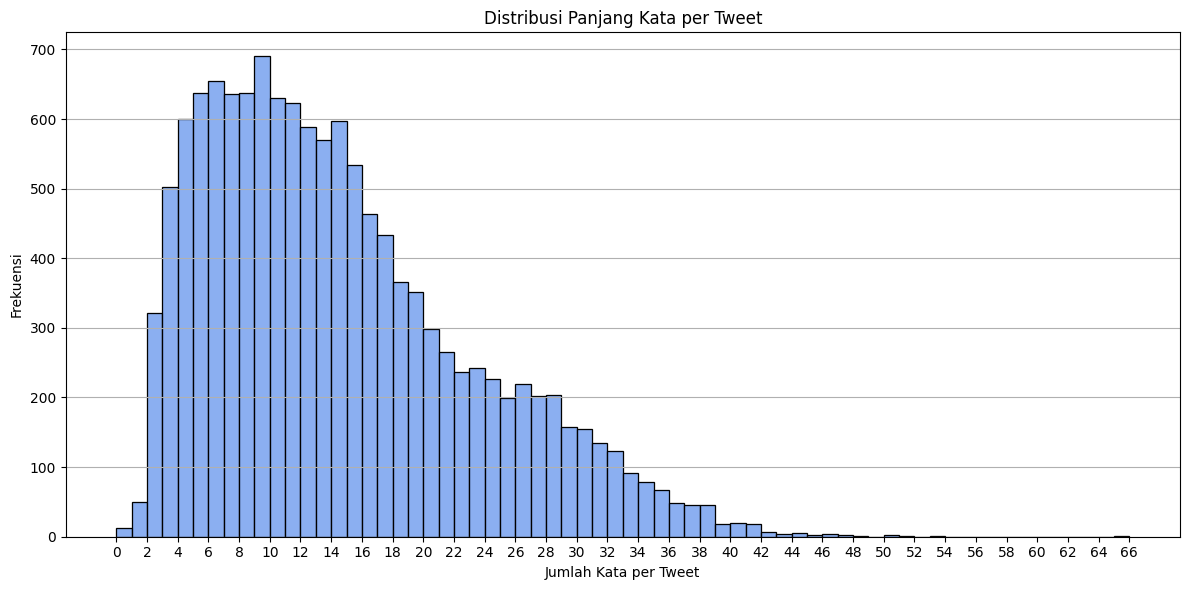

In [ ]:
# Hitung jumlah kata per tweet
preprocessed_data['word_count'] = preprocessed_data['Tweet'].apply(lambda x: len(str(x).split()))

# Statistik deskriptif
print("Statistik jumlah kata per tweet:")
print(preprocessed_data['word_count'].describe())

# Ambil nilai maksimum word count untuk penyesuaian xticks
max_word_count = preprocessed_data['word_count'].max()

# Visualisasi dengan xticks yang lebih rapat
plt.figure(figsize=(12, 6))
sns.histplot(preprocessed_data['word_count'], bins=range(0, max_word_count + 1), kde=False, color='cornflowerblue')
plt.title('Distribusi Panjang Kata per Tweet')
plt.xlabel('Jumlah Kata per Tweet')
plt.ylabel('Frekuensi')
plt.xticks(np.arange(0, max_word_count + 1, step=2))  # Tampilkan tiap 2 kata, bisa diganti jadi 1 untuk lebih detail
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Filter data dengan jumlah kata <= 2
short_tweets = preprocessed_data[preprocessed_data['word_count'] < 2]

# Tampilkan hasil
print(f"Jumlah tweet dengan < 2 kata: {len(short_tweets)}\n")
print(short_tweets[['Tweet', 'word_count']])

Jumlah tweet dengan < 2 kata: 62

               Tweet  word_count
158            bebal           1
182                            0
288                            0
318                            0
354             cina           1
377                            0
451            bolot           1
490                            0
534            cocot           1
702            salah           1
794           jancuk           1
1108           ngewe           1
1282                           0
2316          mampus           1
2707          lekong           1
3047   alhamdulillah           1
3144       kampungan           1
3221         bangkai           1
3293        kejamnya           1
3838                           0
4716          taplak           1
4737           cacat           1
4796            sama           1
5120              no           1
5197           ngewe           1
5233         kampang           1
5444                           0
5514          sampah           1
5656     

In [ ]:
# Hapus baris dengan word count < 2
preprocessed_data = preprocessed_data[preprocessed_data['word_count'] >= 2]

# Hapus kolom word_count
preprocessed_data.drop(columns=['word_count'], inplace=True)

<ipython-input-30-5bbf4e823bc9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocessed_data.drop(columns=['word_count'], inplace=True)


In [ ]:
# Tampilkan jumlah data setelah dibersihkan
print(preprocessed_data.shape)

(12961, 10)


In [ ]:
preprocessed_data.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other
0,saat semua cowok berusaha melacak perhatian gue kamu lantas remehkan perhatian gue kasih khusus kamu basic kamu cowok bego,1,1,1,0,0,0,0,0,1
1,siapa telat memberi tau kamu edan sarap gue bergaul cigax jifla calis sama siapa licew,0,1,0,0,0,0,0,0,0
2,kadang aku berpikir aku tetap percaya tuhan padahal aku selalu jatuh berkali kali kadang aku merasa tuhan meninggalkan aku sendirian orang tuaku berencana berpisah kakakku lebih memilih jadi kristen aku anak ter,0,0,0,0,0,0,0,0,0
3,aku aku ku tau matamu sipit dilihat mana aku,0,0,0,0,0,0,0,0,0
4,kaum cebong kafir kelihatan dongoknya awal tambah dungu haha,1,1,0,1,1,0,0,0,0


#Menyimpan Preprocessed Dataset

In [ ]:
preprocessed_data.to_csv("preprocessed_data.csv", index=False)

In [ ]:
# salin mini_df ke google drive
import shutil

shutil.copy("preprocessed_data.csv", "/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/preprocessed_data.csv")

'/content/drive/MyDrive/Colab Notebooks/Tugas Akhir/preprocessed_data.csv'